<center>
 <img src = "https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png">
 </center>
 
# Machine Learning with JAX
This notebook is a practical attempt towards building a simple machine learning framework based on JAX. For more resources including papers, blog posts, tutorial, and documentation refer to [awsome-JAX repo](https://github.com/n2cholas/awesome-jax#tutorials-and-blog-posts).
<br>
<br>

## Recap
Python frameworks has dominated the world of machine learning and deep learning by providing user friendly high-level libraries. Such as numpy, sklearn, pytorch, and tensorflow.[\[ 2 \]](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
<br>
<br>

While these libraries are suitable to general users, python being an interpretable dynamic language and numpy being only designed for cpu make them inadequate for the research community.

JAX, hence, is aiming to solve the following shortcomming in the current ML/DL echosystem:

* Accelerator agnostic library
* Auto Defferentiation support
* Optimizing operations
* Speed-up by micro-operation optimization
* Easy vectorization
* Reproducable multi-accelerator training(RNG)
<br>
<br>

## Points to remember before moving forward
 * JAX is a python machine learning framework developed in Google Research Team [\[1\]](https://www.deepmind.com/blog/using-jax-to-accelerate-our-research)
 * JAX API was designed based on Numpy --> easy to employ
 * JAX includes an extensible system of composable function transformations that help support machine learning research:
 
$\qquad$ 1. Differentiation

$\qquad$ 2. Vectorisation

$\qquad$ 3. JIT-compilation(speed up)


In [50]:
# Let's import the necessary packages
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

## Sateful and Stateless modules
In machine learning, program state most often comes in the form of:

* model parameters,
* Optimizer state, and
* stateful layers, such as BatchNorm.

Some JAX transformations, most notably jax.jit, impose constraints on the functions they transform. In particular, the function transformed by jax.jit must have no side-effects.

This is because any such side-effects will only be executed once, when the python version of the function is run during compilation. These side-effects will not be executed by the compiled function on subsequent runs.

In [51]:
from IPython.display import HTML
HTML('<center><iframe width="1000" height="630" src="https://www.youtube.com/embed/3qnX1OXQ3Ws" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

In [52]:
# 1) We've seen in the last notebook/video that impure functions are problematic.

g = 0.  # state

# We're accessing some external state in this function which causes problems
def impure_uses_globals(x):
    return x + g

# JAX captures the value of the global/state during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global/state!
g = 10.

# Subsequent runs may silently use the cached value of the globals/state
print ("Second call: ", jit(impure_uses_globals)(5.))

First call:  4.0
Second call:  5.0


In [53]:
# 2) We've also seen this pattern how JAX's PRNG 
# (which is not stateful in contrast to NumPy's PRNG) is handling state.

seed = 0
state = jax.random.PRNGKey(seed)

# We input the state, we somehow manipulate it and we return it back.
# The state is not saved internally.
state1, state2 = jax.random.split(state)  # recall: key/subkey was the terminology we used

In [54]:
# Let's now explictly address and understand the problem of state!
# Why? 
# Well, NNs love statefulness: model params, optimizer params, BatchNorm, etc.
# and we've seen that JAX seems to have a problem with it.

class Counter:
    """A simple counter."""

    def __init__(self):
        self.n = 0 

    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n

    def reset(self):
        """Resets the counter to zero."""
        self.n = 0


counter = Counter()

for _ in range(3):  # works like a charm
    print(counter.count())

1
2
3


In [55]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):  # oops, it's not working as it's supposed to be
    print(fast_count())

1
1
1


In [56]:
from jax import make_jaxpr  # let's use jaxpr to understand why this is happening

counter.reset()
print(make_jaxpr(counter.count)())

{ lambda ; . let  in (1,) }


## The solution: explicit state

Part of the problem with our counter was that the returned value didn’t depend on the arguments, meaning a constant was “baked into” the compiled output. But it shouldn’t be a constant – it should depend on the state. Well, then why don’t we make the state into an argument?

In summary we used the following rule to convert a stateful class:

```python
class StatefulClass

    state: State

    def stateful_method(*args, **kwargs) -> Output:
```

into a class of the form:

```python
class StatelessClass

    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

In [57]:
# Solution:

CounterState = int  # our counter state is implemented as a simple integer

class CounterV2:

    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # You could just return n+1, but here we separate its role as 
        # the output and as the counter state for didactic purposes.
        # (as the output may be some arbitrary function of state in general case)
        return n+1, n+1

    def reset(self) -> CounterState:
        return 0

counter = CounterV2()
state = counter.reset()  # notice how reset() now returns state (external vs internal imp)

for _ in range(3):  # works like a charm pre-jit, let's see whether the jit version works
    value, state = counter.count(state)  # looks familiar?
    print(value)

1
2
3


In [58]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):  # nice, working as expected!
    value, state = fast_count(state)
    print(value)

1
2
3


## Working with nested structures

Often, we want to operate on objects that look like dicts of arrays, or lists of lists of dicts, or other nested structures. In JAX, we refer to these as pytrees, but you can sometimes see them called nests, or just trees.

JAX has built-in support for such objects, both in its library functions as well as through the use of functions from jax.tree_utils (with the most common ones also available as jax.tree_*). This section will explain how to use them, give some useful snippets and point out common gotchas.

## What is a pytree?
a pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts. A leaf element is anything that’s not a pytree, e.g. an array. In other words, a pytree is just a possibly-nested standard or user-registered Python container. If nested, note that the container types do not need to match. A single “leaf”, i.e. a non-container object, is also considered a pytree.

## Why pytrees?!

In machine learning, some places where you commonly find pytrees are:

* Model parameters
* Dataset entries
* RL agent observations
* They also often arise naturally when working in bulk with datasets (e.g., lists of lists of dicts).



In [59]:
from IPython.display import HTML
HTML('<center><iframe width="1000" height="630" src="https://www.youtube.com/embed/GCIix53G5pM" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

In [60]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2  # + 175B params more (minus 4)

# JAX: .backward() is not that great
# also JAX:
x, y, z, w = [1.]*4
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
print(dfdx, dfdy, dfdz, dfdw)

# Great now we just need to update our params!
# lr = 0.001
# x -= lr*dfdx
# y -= lr*dfdy
# ... (175B lines later)
# w -= lr*dfdw

# No, no, no. 
# We do have a better way.

2.0 2.0 2.0 2.0


No, no, no. 
We do have a better way!

We want to, more naturally, wrap our params in some more complex data structures like dictionaries, etc.  

JAX knows how to deal with these! The answer is called a **PyTree**.

In [61]:
# A contrived example for pedagogical purposes
# (if your mind needs to attach some semantics to parse this - treat it as model params)
pytree_example = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in pytree_example:
    leaves = jax.tree_leaves(pytree)  # handy little function
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7fa813923980>]   has 3 leaves: [1, 'a', <object object at 0x7fa813923980>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


<ipython-input-61-e8c0dbd1dca6>:13: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  leaves = jax.tree_leaves(pytree)  # handy little function


In [62]:
# How do we manipulate PyTrees?

list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

# For single arg functions use tree_map
# tree_map iterates through leaves and applies the lambda function
print(jax.tree_map(lambda x: x*2, list_of_lists)) 

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [63]:
another_list_of_lists = list_of_lists
print(jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [64]:
# PyTrees need to have the same structure if we are to apply tree_multimap!
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append([23])
print(jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

ValueError: ignored

## MLP with JAX + Pytrees
A simple example of training an MLP displays some ways in which pytree operations come in useful:

In [65]:
def init_mlp_params(layer_widths):
    params = []

    # Allocate weights and biases (model parameters)
    # Notice: we're not using JAX's PRNG here - doesn't matter for this simple example
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                biases=np.ones(shape=(n_out,))
        )
    )

    return params

# Instantiate a single input - single output, 3 layer (2 hidden layers) deep MLP
params = init_mlp_params([1, 128, 128, 1])

# Another example of how we might use tree_map - verify that shapes make sense:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [66]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)  # MSE loss

lr = 0.0001

@jit  # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees!
    grads = jax.grad(loss_fn)(params, x, y)

    # Task: analyze grads and make sure it has the same structure as params

    # SGD update
    return jax.tree_map(
        lambda p, g: p - lr * g, params, grads  # for every leaf i.e. for every param of MLP
    )

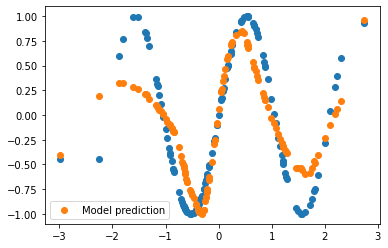

In [70]:
xs = np.random.normal(size=(128, 1))
ys = jnp.sin(3*xs)  # let's learn how to regress a parabola

# Task experiment a bit with other functions (polynomials, sin, etc.)

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)  # again our lovely pattern

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

### Custom PyTrees

So far, we’ve only been considering pytrees of lists, tuples, and dicts; everything else is considered a leaf. Therefore, if you define your own container class, it will be considered a leaf, even if it has trees inside it:

In [71]:
class MyContainer:  # this could be a linear layer a conv layer or whatever
    """A named container."""
    def __init__(self, name: str, a: int, b: int, c: int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c

In [72]:
example_pytree = [MyContainer('Alice', 1, 2, 3), MyContainer('Bob', 4, 5, 6)]  # 8 leaves? Right? Noup.

leaves = jax.tree_leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7fa815280490>, <__main__.MyContainer object at 0x7fa815280250>]
 has 2 leaves:
 [<__main__.MyContainer object at 0x7fa815280490>, <__main__.MyContainer object at 0x7fa815280250>]


<ipython-input-72-c5e0b4631d08>:3: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  leaves = jax.tree_leaves(example_pytree)


In [73]:
print(jax.tree_map(lambda x: x + 1, example_pytree))  # this will not work :/ it'd be nice if it did

TypeError: ignored

To solve this, we need to register our container with JAX by telling it how to flatten and unflatten it:

In [24]:
# Let's get it to work! We'll need to define 2 functions (flatten/unflatten)

def flatten_MyContainer(container):
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name

    return flat_contents, aux_data

def unflatten_MyContainer(aux_data, flat_contents):
    """Converts aux data and the flat contents into a MyContainer."""
    return MyContainer(aux_data, *flat_contents)

# Register a custom PyTree node
jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflatten_MyContainer)

In [25]:
# Let's try again!
leaves = jax.tree_leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7fa813914b50>, <__main__.MyContainer object at 0x7fa813914e50>]
 has 6 leaves:
 [1, 2, 3, 4, 5, 6]


<ipython-input-25-a3cbc04b51ae>:2: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  leaves = jax.tree_leaves(example_pytree)


In [26]:
# Let's try applying tree map again
result = jax.tree_map(lambda x: x + 1, example_pytree)
print(jax.tree_leaves(result))  # it works now as expected!

[2, 3, 4, 5, 6, 7]


<ipython-input-26-0ea77d340edb>:3: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  print(jax.tree_leaves(result))  # it works now as expected!


Great! We can now create custom layers and we can train even bigger neural networks!

But what if our neural network is really big? How do we handle training it across multiple devices? 

I'm glad you asked.

## Parallelism in JAX

In this section we will discuss the facilities built into JAX for single-program, multiple-data (SPMD) code.

SPMD refers to a parallelism technique where the same computation (e.g., the forward pass of a neural net) is run on different input data (e.g., different inputs in a batch) in parallel on different devices (e.g., several TPUs).

Conceptually, this is not very different from vectorisation, where the same operations occur in parallel in different parts of memory on the same device. We have already seen that vectorisation is supported in JAX as a program transformation, jax.vmap. JAX supports device parallelism analogously, using jax.pmap to transform a function written for one device into a function that runs in parallel on multiple devices.

In [27]:
from IPython.display import HTML
HTML('<center><iframe width="1000" height="630" src="https://www.youtube.com/embed/W1vfBDFLm7Q" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

# `pmap` basics

## Colab TPU Setup

If you’re running this code in Google Colab, be sure to choose Runtime→Change Runtime Type and choose TPU from the Hardware Accelerator menu.

Once this is done, you can run the following to set up the Colab TPU for use with JAX:

In [74]:
# Let's try to get ourselves some TPU goodness
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [75]:
# Let's use a simple running example here
x = np.arange(5)  # signal
w = np.array([2., 3., 4.])  # window/kernel

def convolve(w, x):  # implementation of 1D convolution/correlation
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    return jnp.array(output)

result = convolve(w, x)
print(repr(result))

DeviceArray([11., 20., 29.], dtype=float32)


In [76]:
n_devices = jax.local_device_count() 
print(f'Number of available devices: {n_devices}')

# Let's now imagine we have a much heavier load (a batch of examples)
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

print(xs.shape, ws.shape)

Number of available devices: 8
(8, 5) (8, 3)


In [77]:
# First way to optimize this is to simply use vmap
vmap_result = jax.vmap(convolve)(ws, xs)
print(repr(vmap_result))

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.]], dtype=float32)


In [78]:
# The amazing thing is if you just swap vmap for pmap you are now running on multiple
# devices. How cool is that?
pmap_result = jax.pmap(convolve)(ws, xs)
print(repr(pmap_result))  # ShardedDeviceArray!

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)


In [79]:
# No cross-device communication costs. Computations are done independently on each dev.
double_pmap_result = jax.pmap(convolve)(jax.pmap(convolve)(ws, xs), xs)
print(repr(double_pmap_result))

ShardedDeviceArray([[   78.,   138.,   198.],
                    [ 1188.,  1383.,  1578.],
                    [ 3648.,  3978.,  4308.],
                    [ 7458.,  7923.,  8388.],
                    [12618., 13218., 13818.],
                    [19128., 19863., 20598.],
                    [26988., 27858., 28728.],
                    [36198., 37203., 38208.]], dtype=float32)


In [34]:
# Same results but we don't have to manually broadcast w (recall: same as for vmap!)
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)


This is all great, but oftentimes we do need to communicate between devices. 📱

Let's see how that is handled.

### Communication between devices

In [35]:
# Same example as above but this time we communicate across devices 
# in order to normalize the outputs
def normalized_convolution(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    output = jnp.array(output)  # same result as before

    return output / jax.lax.psum(output, axis_name='batch_dim')  # this is where communication happens

res_pmap = jax.pmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)
res_vmap = jax.vmap(normalized_convolution, axis_name='batch_dim', in_axes=(None, 0))(w, xs)

print(repr(res_pmap))
print(repr(res_vmap))

print(f'Verify the output is normalized: {sum(res_pmap[:, 0])}')

ShardedDeviceArray([[0.00816024, 0.01408451, 0.019437  ],
                    [0.04154303, 0.04577465, 0.04959785],
                    [0.07492582, 0.07746479, 0.07975871],
                    [0.10830861, 0.10915492, 0.10991956],
                    [0.14169139, 0.14084506, 0.14008042],
                    [0.17507419, 0.17253521, 0.17024128],
                    [0.20845698, 0.20422535, 0.20040214],
                    [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
DeviceArray([[0.00816024, 0.01408451, 0.019437  ],
             [0.04154303, 0.04577465, 0.04959785],
             [0.07492582, 0.07746479, 0.07975871],
             [0.10830861, 0.10915492, 0.10991956],
             [0.14169139, 0.14084506, 0.14008042],
             [0.17507419, 0.17253521, 0.17024128],
             [0.20845698, 0.20422535, 0.20040214],
             [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Verify the output is normalized: 1.0


We're now ready to see the most complex model pipeline so far in JAX.

### Training a very simple model in parallel!

In [80]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray


lr = 0.005


def init_model(rng):
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)


def forward(params, xs):
    return params.weight * xs + params.bias


def loss_fn(params, xs, ys):
    pred = forward(params, xs)
    return jnp.mean((pred - ys) ** 2)  # MSE


@functools.partial(jax.pmap, axis_name='batch')
def update(params, xs, ys):

    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='batch')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='batch')

    # Each device performs its own SGD update, but since we start with the same params
    # and synchronise gradients, the params stay in sync on each device.
    new_params = jax.tree_map(
        lambda param, g: param - g * lr, params, grads)
    
    # If we were using Adam or another stateful optimizer,
    # we would also do something like:
    # updates, new_optimizer_state = optimizer(grads, optimizer_state)
    # and then use updates instead of grads to actually update the params.
    # (And we'd include the new_optimizer_state in the output, naturally.)

    return new_params, loss

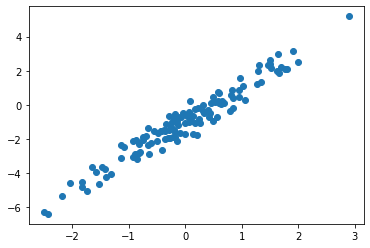

In [81]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

plt.scatter(xs, ys)
plt.show()

In [82]:
# Initialise parameters and replicate across devices.
params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
print(replicated_params)

# Prepare the data
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

Params(weight=DeviceArray([0.14389051, 0.14389051, 0.14389051, 0.14389051, 0.14389051,
             0.14389051, 0.14389051, 0.14389051], dtype=float32), bias=DeviceArray([-1.2515285, -1.2515285, -1.2515285, -1.2515285, -1.2515285,
             -1.2515285, -1.2515285, -1.2515285], dtype=float32))
(8, 16, 1) (8, 16, 1)


In [83]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a {type(obj)}")

# Actual training loop
num_epochs = 1000
for epoch in range(num_epochs):

    # This is where the params and data gets communicated to devices
    replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

    # replicated_params and loss are now both ShardedDeviceArrays,
    # indicating that they're on the devices.
    # x/y_parallel remains a NumPy array on the host (simulating data streaming).
    if epoch == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_parallel', x_parallel)

    if epoch % 100 == 0:
        print(loss.shape)
        print(f"Step {epoch:3d}, loss: {loss[0]:.3f}")

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))

after first `update()`, `replicated_params.weight` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `loss` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `x_parallel` is a <class 'numpy.ndarray'>
(8,)
Step   0, loss: 3.563
(8,)
Step 100, loss: 0.691
(8,)
Step 200, loss: 0.291
(8,)
Step 300, loss: 0.236
(8,)
Step 400, loss: 0.228
(8,)
Step 500, loss: 0.227
(8,)
Step 600, loss: 0.227
(8,)
Step 700, loss: 0.227
(8,)
Step 800, loss: 0.227
(8,)
Step 900, loss: 0.227


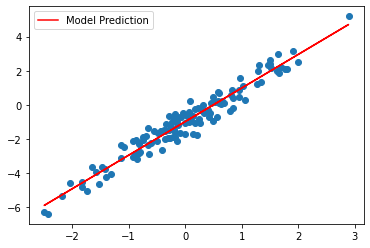

In [84]:
plt.scatter(xs, ys)
plt.plot(xs, forward(params, xs), c='red', label='Model Prediction')
plt.legend()
plt.show()